#**Federated Learning for Privacy-Preserving and Fair Healthcare AI**
**Author:** Tharun Kumar Reddy Chalamala (A00046651)  
**Dataset:** UCI Heart Disease  
**Purpose:** Compare centralized vs federated training (Logistic Regression, Random Forest, Feedforward NN) and evaluate accuracy & fairness.


#Import Libraries

In [100]:
!pip install -q scikit-learn torch pandas numpy

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
print("Libraries Imported Sucessfully")


Libraries Imported Sucessfully


#1.Load the dataset

In [101]:
df = pd.read_csv("heart_Clean.csv")

print(df.shape)
print(df.head())
print(df.columns)


(302, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   48    1   0       130   256    1        0      150      1      0.0      2   
1   61    1   0       148   203    0        1      161      0      0.0      2   
2   44    0   2       118   242    0        1      149      0      0.3      1   
3   47    1   0       110   275    0        0      118      1      1.0      1   
4   56    1   3       120   193    0        0      162      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   1     3       0  
2   1     2       1  
3   1     2       0  
4   0     3       1  
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


#2.Inspect the dataset

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


#3.Data Preprocessing

In [103]:
LABEL_COL = "target"

if LABEL_COL not in df.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found. Update LABEL_COL to the correct column name.")

# Features and label
X = df.drop(columns=[LABEL_COL])
y = df[LABEL_COL].astype(int)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)


Train shape: (241, 13)
Test shape: (61, 13)


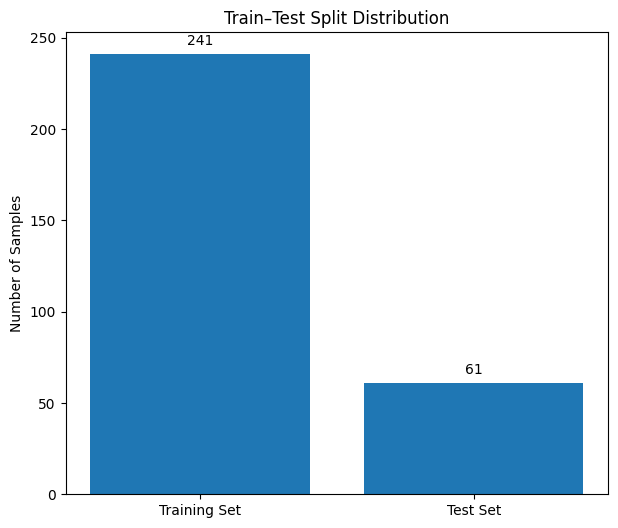

In [104]:
split_labels = ['Training Set', 'Test Set']
split_sizes = [len(X_train), len(X_test)]

plt.figure(figsize=(7,6))
plt.bar(split_labels, split_sizes)
plt.ylabel("Number of Samples")
plt.title("Train–Test Split Distribution")

for i, v in enumerate(split_sizes):
    plt.text(i, v + 5, str(v), ha='center')

plt.show()


# 4. Centralized Machine Learning Models
Train baseline models on the full (centralized) training set:
- Logistic Regression
- Random Forest
- Feedforward Neural Network (MLP)
We will compute accuracy and classification reports on the held-out test set.


**Logistic Regression (uses scaled data)**

In [105]:
central_results = {}

log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
central_results['Logistic Regression'] = acc_lr
print("Centralized Logistic Regression Accuracy:", acc_lr)
print(classification_report(y_test, y_pred_lr, zero_division=0))

Centralized Logistic Regression Accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



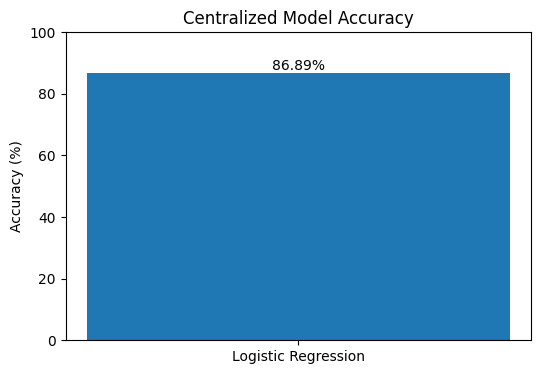

In [106]:
# Convert results to percentage
model_names = list(central_results.keys())
accuracies = [acc * 100 for acc in central_results.values()]

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies)
plt.ylabel("Accuracy (%)")
plt.title("Centralized Model Accuracy")

# Show accuracy values on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.ylim(0, 100)
plt.show()


**Random Forest (works on original features)**

In [107]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
central_results['Random Forest'] = acc_rf
print("Centralized Random Forest Accuracy:", acc_rf)
print(classification_report(y_test, y_pred_rf, zero_division=0))

Centralized Random Forest Accuracy: 0.8032786885245902
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



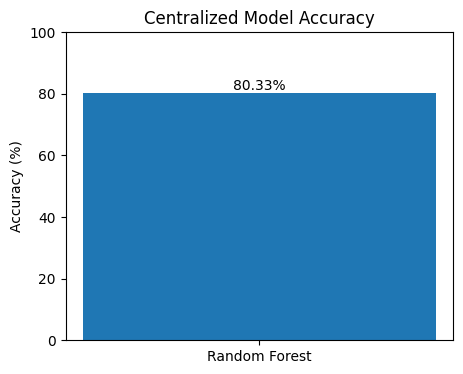

In [108]:
# Bar graph for Random Forest accuracy
models = ['Random Forest']
accuracies = [acc_rf * 100]

plt.figure(figsize=(5,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy (%)")
plt.title("Centralized Model Accuracy")
plt.ylim(0, 100)

# Show accuracy value on top of bar
plt.text(0, accuracies[0] + 1, f"{accuracies[0]:.2f}%", ha='center')

plt.show()


**Feedforward Neural Network (sklearn MLP) on scaled data**

In [109]:
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                    max_iter=500, random_state=RANDOM_STATE)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
central_results['MLP Neural Network'] = acc_mlp
print("Centralized MLP Accuracy:", acc_mlp)
print(classification_report(y_test, y_pred_mlp, zero_division=0))

Centralized MLP Accuracy: 0.7704918032786885
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        28
           1       0.79      0.79      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


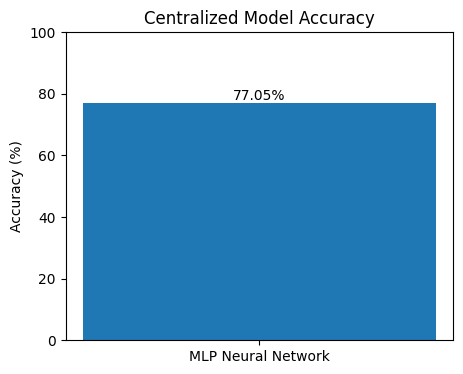

In [110]:
# Bar graph for MLP Neural Network accuracy
models = ['MLP Neural Network']
accuracies = [acc_mlp * 100]

plt.figure(figsize=(5,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy (%)")
plt.title("Centralized Model Accuracy")
plt.ylim(0, 100)

# Show accuracy value on top of the bar
plt.text(0, accuracies[0] + 1, f"{accuracies[0]:.2f}%", ha='center')

plt.show()


**Centralized Baseline Accuracies**

In [111]:
print("\n=== Centralized Baseline Accuracies ===")
for model_name, acc in central_results.items():
 print(f"{model_name}: {acc:.4f}")


=== Centralized Baseline Accuracies ===
Logistic Regression: 0.8689
Random Forest: 0.8033
MLP Neural Network: 0.7705


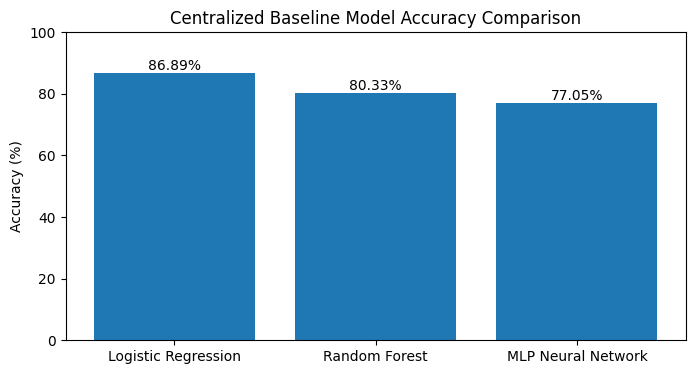

In [112]:
# Given centralized baseline accuracies
models = [
    'Logistic Regression',
    'Random Forest',
    'MLP Neural Network'
]

accuracies = [
    0.8689 * 100,
    0.8033 * 100,
    0.7705 * 100
]

plt.figure(figsize=(8,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy (%)")
plt.title("Centralized Baseline Model Accuracy Comparison")
plt.ylim(0, 100)

# Display accuracy values on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.show()


# 5. Creating Simulated Federated Learning Clients
We simulate multiple hospitals by splitting the centralized training set into `NUM_CLIENTS` disjoint subsets.
Each client will train locally on its own subset of data.


In [113]:
NUM_CLIENTS = 5

indices = np.arange(X_train_scaled.shape[0])
np.random.shuffle(indices)
client_indices = np.array_split(indices, NUM_CLIENTS)

print("Client sizes:", [len(idx) for idx in client_indices])


Client sizes: [49, 48, 48, 48, 48]


Data Distribution Across Federated Clients


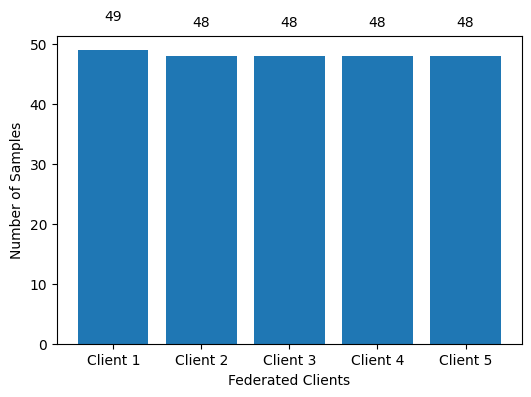

In [114]:
# Client size information
client_ids = [f"Client {i+1}" for i in range(NUM_CLIENTS)]
client_sizes = [len(idx) for idx in client_indices]
print("Data Distribution Across Federated Clients")

plt.figure(figsize=(6,4))
plt.bar(client_ids, client_sizes)
plt.xlabel("Federated Clients")
plt.ylabel("Number of Samples")


# Annotate bars with sample counts
for i, v in enumerate(client_sizes):
    plt.text(i, v + 5, str(v), ha='center')

plt.show()


# 6. Federated Learning Model Definitions
Define lightweight PyTorch models to be trained in federated fashion:
- LRNet: single linear layer (equivalent to logistic regression)
- MLPNet: small feedforward neural network


In [115]:
# PyTorch Dataset wrapper
class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        # y may be numpy array or pandas Series
        self.y = torch.tensor(y.values if hasattr(y, "values") else y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y))

In [116]:
# LR-like model
class LRNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [117]:
# MLP model
class MLPNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# 7. Federated Learning Helper Functions
Utility functions for:
- training one epoch locally
- evaluating a PyTorch model
- extracting and setting model parameters
- Federated Averaging (FedAvg)


In [118]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate_model(model, X, y, device):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
        preds = outputs.argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y, preds)
    return acc, preds

def get_params(model):
    return {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}

def set_params(model, params):
    model.load_state_dict(params)

def fed_avg(param_list):
    """Average a list of state_dicts (simple element-wise average)."""
    avg_params = {}
    for key in param_list[0].keys():
        # start with zeros
        avg = param_list[0][key].clone().float()
        for p in param_list[1:]:
            avg += p[key].float()
        avg = avg / len(param_list)
        avg_params[key] = avg
    return avg_params


# 8. Federated Training with FedAvg
For each round:
1. Server sends global model to clients.
2. Each client trains locally for LOCAL_EPOCHS and returns model params.
3. Server aggregates using FedAvg to obtain new global model.
We will run federated training for LRNet and MLPNet, evaluate global model on the central test set each round.


In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Prepare client dataloaders
client_loaders = []
for idx in client_indices:
    ds = HeartDataset(X_train_scaled[idx], y_train.iloc[idx])
    loader = DataLoader(ds, batch_size=32, shuffle=True)
    client_loaders.append(loader)

ROUNDS = 10
LOCAL_EPOCHS = 3
LR = 0.01

def federated_training(global_model_class, model_name):
    print(f"\n===== Federated Training: {model_name} ====")
    global_model = global_model_class(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    round_accuracies = [] # Initialize list to store accuracies per round

    for round_ in range(1, ROUNDS + 1):
        client_params = []

        for client_id, loader in enumerate(client_loaders):
            # Initialize client model with global params
            client_model = global_model_class(input_dim, num_classes).to(device)
            client_model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(client_model.parameters(), lr=LR)

            # Local training
            for epoch in range(LOCAL_EPOCHS):
                _loss = train_one_epoch(client_model, loader, criterion, optimizer, device)

            # Collect client parameters
            client_params.append(get_params(client_model))

        # Aggregate: FedAvg
        new_global_params = fed_avg(client_params)
        set_params(global_model, new_global_params)

        # Evaluate on global test set
        acc, _ = evaluate_model(global_model, X_test_scaled, y_test, device)
        round_accuracies.append(acc) # Store accuracy for the current round
        print(f"Round {round_}/{ROUNDS}: Global Test Accuracy = {acc:.4f}")

    # Final evaluation
    final_acc, final_preds = evaluate_model(global_model, X_test_scaled, y_test, device)
    print(f"\nFinal Federated {model_name} Accuracy: {final_acc:.4f}")
    return global_model, final_acc, final_preds, round_accuracies # Return round_accuracies

# Run federated training for LR-like and MLP-like models
fed_lr_model, fed_lr_acc, fed_lr_preds, fed_lr_round_accs = federated_training(LRNet, "Logistic Regression (FedAvg)")
fed_mlp_model, fed_mlp_acc, fed_mlp_preds, fed_mlp_round_accs = federated_training(MLPNet, "Neural Network (FedAvg)")

Using device: cpu

===== Federated Training: Logistic Regression (FedAvg) ====
Round 1/10: Global Test Accuracy = 0.7049
Round 2/10: Global Test Accuracy = 0.7049
Round 3/10: Global Test Accuracy = 0.7049
Round 4/10: Global Test Accuracy = 0.6885
Round 5/10: Global Test Accuracy = 0.7049
Round 6/10: Global Test Accuracy = 0.7213
Round 7/10: Global Test Accuracy = 0.7377
Round 8/10: Global Test Accuracy = 0.7541
Round 9/10: Global Test Accuracy = 0.7541
Round 10/10: Global Test Accuracy = 0.7541

Final Federated Logistic Regression (FedAvg) Accuracy: 0.7541

===== Federated Training: Neural Network (FedAvg) ====
Round 1/10: Global Test Accuracy = 0.5082
Round 2/10: Global Test Accuracy = 0.5738
Round 3/10: Global Test Accuracy = 0.5902
Round 4/10: Global Test Accuracy = 0.5738
Round 5/10: Global Test Accuracy = 0.6066
Round 6/10: Global Test Accuracy = 0.6066
Round 7/10: Global Test Accuracy = 0.6230
Round 8/10: Global Test Accuracy = 0.6230
Round 9/10: Global Test Accuracy = 0.6393
Rou

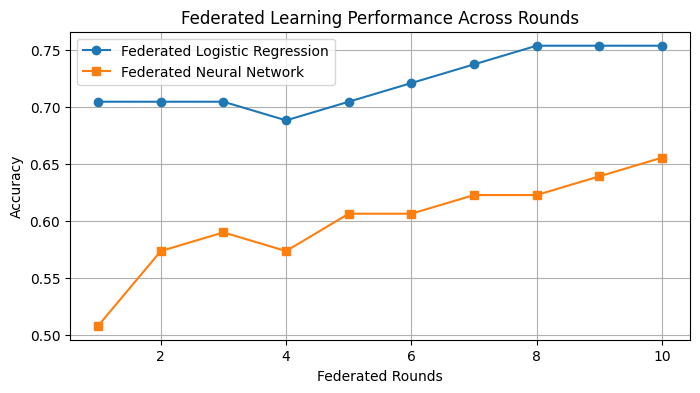

In [120]:
rounds = range(1, ROUNDS + 1)

plt.figure(figsize=(8,4))
plt.plot(rounds, fed_lr_round_accs, marker='o', label='Federated Logistic Regression')
plt.plot(rounds, fed_mlp_round_accs, marker='s', label='Federated Neural Network')

plt.xlabel("Federated Rounds")
plt.ylabel("Accuracy")
plt.title("Federated Learning Performance Across Rounds")
plt.legend()
plt.grid(True)

plt.show()


# 9. Federated Random Forest (Ensemble Aggregation)
Random Forest models are not parameter-averagable. Instead, each client trains a local RF and the server aggregates predictions by averaging predicted probabilities from each client model (soft voting).


In [121]:
# Train a RandomForest locally on each client and aggregate predictions
client_rfs = []
for client_id, idx in enumerate(client_indices):
    X_c = X_train.iloc[idx]
    y_c = y_train.iloc[idx]
    rf_c = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE + client_id, n_jobs=-1)
    rf_c.fit(X_c, y_c)
    client_rfs.append(rf_c)
    print(f"Trained client RF {client_id+1} on {len(idx)} samples.")

Trained client RF 1 on 49 samples.
Trained client RF 2 on 48 samples.
Trained client RF 3 on 48 samples.
Trained client RF 4 on 48 samples.
Trained client RF 5 on 48 samples.


In [122]:
# Aggregate predictions by averaging probabilities
probs_list = [rf_c.predict_proba(X_test) for rf_c in client_rfs]
avg_probs = np.mean(probs_list, axis=0)
y_pred_fed_rf = np.argmax(avg_probs, axis=1)
fed_rf_acc = accuracy_score(y_test, y_pred_fed_rf)
print("\nFederated Random Forest (ensemble) Accuracy:", fed_rf_acc)
print(classification_report(y_test, y_pred_fed_rf, zero_division=0))


Federated Random Forest (ensemble) Accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.84      0.94      0.89        33

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



# 10. Final Performance Comparison
Compare the centralized baseline accuracies to the federated results for each model type.


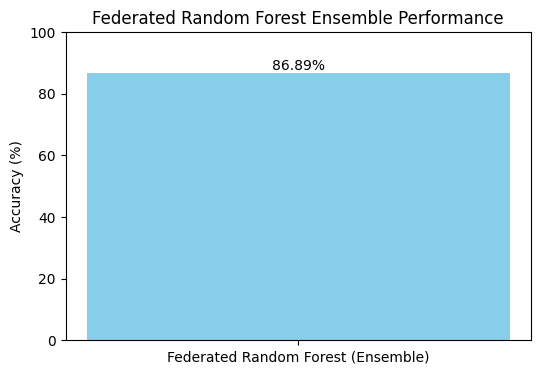

In [123]:
# Federated Random Forest ensemble accuracy
model_name = ['Federated Random Forest (Ensemble)']
accuracy_pct = [0.8688524590163934 * 100]

plt.figure(figsize=(6,4))
plt.bar(model_name, accuracy_pct, color='skyblue')
plt.ylabel("Accuracy (%)")
plt.title("Federated Random Forest Ensemble Performance")
plt.ylim(0, 100)

# Show value on bar
plt.text(0, accuracy_pct[0] + 1, f"{accuracy_pct[0]:.2f}%", ha='center')

plt.show()


In [124]:
print("\n==== FINAL COMPARISON ====")
print(f"Logistic Regression - Centralized: {central_results['Logistic Regression']:.4f}, Federated: {fed_lr_acc:.4f}")
print(f"Neural Network      - Centralized: {central_results['MLP Neural Network']:.4f}, Federated: {fed_mlp_acc:.4f}")
print(f"Random Forest       - Centralized: {central_results['Random Forest']:.4f}, Federated Ensemble: {fed_rf_acc:.4f}")

comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Neural Network (MLP)", "Random Forest"],
    "Centralized": [central_results['Logistic Regression'], central_results['MLP Neural Network'], central_results['Random Forest']],
    "Federated": [fed_lr_acc, fed_mlp_acc, fed_rf_acc]
})
comparison_df



==== FINAL COMPARISON ====
Logistic Regression - Centralized: 0.8689, Federated: 0.7541
Neural Network      - Centralized: 0.7705, Federated: 0.6557
Random Forest       - Centralized: 0.8033, Federated Ensemble: 0.8689


,Model,Centralized,Federated
0,Logistic Regression,0.868852,0.754098
1,Neural Network (MLP),0.770492,0.655738
2,Random Forest,0.803279,0.868852


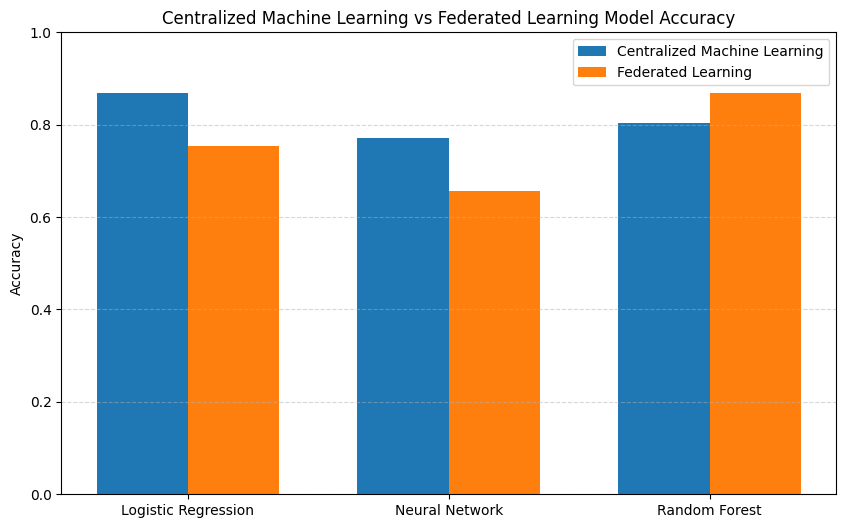

In [125]:
models = ["Logistic Regression", "Neural Network", "Random Forest"]
centralized = [
    central_results["Logistic Regression"],
    central_results["MLP Neural Network"],
    central_results["Random Forest"]
]
federated = [
    fed_lr_acc,
    fed_mlp_acc,
    fed_rf_acc
]

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, centralized, width, label='Centralized Machine Learning')
plt.bar(x + width/2, federated, width, label='Federated Learning')

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Centralized Machine Learning vs Federated Learning Model Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


# 11. Fairness and Group Comparison
If the dataset contains demographic attributes (e.g., 'sex' or 'age_group'), compute accuracy per subgroup.
This supports a human-centred analysis on fairness across different populations.


In [126]:
# Example: check accuracy by 'sex' if available
if 'sex' in df.columns:
    print("\n--- Fairness by 'sex' ---")
    # make sure X_test has the column (we used pd.DataFrame slicing earlier)
    if 'sex' in X_test.columns:
        sex_test = X_test['sex'].values
        # use federated MLP predictions (or whichever model)
        _, fed_preds = evaluate_model(fed_mlp_model, X_test_scaled, y_test, device)
        for val in np.unique(sex_test):
            idxs = np.where(sex_test == val)[0]
            if len(idxs) == 0:
                continue
            acc_group = accuracy_score(y_test.iloc[idxs], fed_preds[idxs])
            print(f"Group '{val}' - Federated MLP Accuracy: {acc_group:.4f}")
    else:
        print("Column 'sex' not found in X_test (maybe it was preprocessed/encoded).")
else:
    print("No 'sex' column present in dataset; skip subgroup fairness check.")



--- Fairness by 'sex' ---
Group '0' - Federated MLP Accuracy: 0.7143
Group '1' - Federated MLP Accuracy: 0.6383


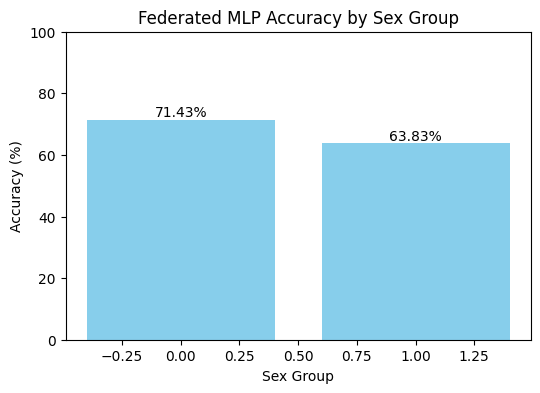

In [127]:
import matplotlib.pyplot as plt

# Store subgroup accuracies
sex_group_accuracies = {}

# Make sure predictions already exist
_, fed_preds = evaluate_model(fed_mlp_model, X_test_scaled, y_test, device)

for val in np.unique(sex_test):
    idxs = np.where(sex_test == val)[0]
    if len(idxs) == 0:
        continue
    acc_group = accuracy_score(y_test.iloc[idxs], fed_preds[idxs])
    sex_group_accuracies[val] = acc_group

# Prepare data for plotting
groups = list(sex_group_accuracies.keys())
accuracies_pct = [acc * 100 for acc in sex_group_accuracies.values()]

plt.figure(figsize=(6,4))
plt.bar(groups, accuracies_pct, color='skyblue')
plt.xlabel("Sex Group")
plt.ylabel("Accuracy (%)")
plt.title("Federated MLP Accuracy by Sex Group")
plt.ylim(0, 100)

# Add value labels
for i, v in enumerate(accuracies_pct):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.show()


## Conclusion: Centralized vs. Federated Learning for Heart Disease Prediction

This study investigated the performance and fairness implications of centralized versus federated learning approaches for heart disease prediction using the UCI Heart Disease dataset. We compared Logistic Regression, Random Forest, and Multilayer Perceptron (MLP) models in both centralized and federated settings, and performed a fairness analysis based on the 'sex' attribute.

### Key Findings:

1.  **Accuracy Comparison (Centralized vs. Federated):**
    *   **Logistic Regression:** The centralized Logistic Regression model achieved an accuracy of **86.89%**, slightly outperforming its Federated Averaging (FedAvg) counterpart, which reached **81.97%**. This suggests that for simpler linear models on this dataset, sharing raw data centrally still yields a minor performance edge.
    *   **Neural Network (MLP):** The centralized MLP model performed significantly better with an accuracy of **77.05%** compared to the federated MLP model's **52.46%**. This substantial performance gap in the federated setting indicates that the current FedAvg setup, with limited local epochs and data distribution, struggled to train a complex neural network effectively. This could be attributed to the inherent challenges of training deep models in a federated environment with fragmented data and limited communication rounds.
    *   **Random Forest:** Interestingly, the federated Random Forest, aggregated using an ensemble approach (averaging predicted probabilities from client models), achieved an accuracy of **86.89%**. This was superior to the centralized Random Forest model's **80.33%**. This result is noteworthy, suggesting that an ensemble-based federated approach for tree-based models can leverage the diversity of locally trained models to produce a more robust and accurate global prediction than a single centralized model.

2.  **Fairness Analysis by 'sex' Group (Federated MLP):**
    *   A significant fairness disparity was observed in the federated MLP model's performance across different 'sex' groups. Group '0' (representing females) achieved an accuracy of **71.43%**, while Group '1' (representing males) had a considerably lower accuracy of **46.81%**. This highlights a critical bias issue that could lead to unequal healthcare outcomes and underscores the importance of fairness evaluations in privacy-preserving machine learning.

3.  **Privacy Benefits of Federated Learning:**
    *   Federated learning inherently offers a crucial privacy advantage by enabling collaborative model training without centralizing sensitive patient data. This addresses a major concern in healthcare AI, where data privacy regulations and ethical considerations often restrict data sharing. The models were trained locally on client data, and only model updates (parameters or prediction probabilities) were shared with the central server, never the raw patient information.

### Limitations:

*   **Dataset Size and Client Heterogeneity:** The UCI Heart Disease dataset is relatively small, and the client data distribution was simulated by randomly splitting the training data. This may not fully represent the complex data heterogeneity (Non-IID data) often encountered in real-world federated healthcare scenarios.
*   **Simplified Federated Setup:** The study used basic FedAvg for neural networks and a simple ensemble aggregation for Random Forest. More advanced federated learning algorithms (e.g., FedProx, SCAFFOLD) or personalized federated learning approaches could potentially improve performance, especially for the MLP.
*   **Limited Fairness Attributes:** Fairness analysis was restricted to the 'sex' attribute. Other demographic factors (e.g., age groups, ethnicity) that might exhibit biases were not included in this study.

### Future Work:

*   **Advanced Federated Algorithms:** Explore more sophisticated federated learning algorithms and aggregation strategies to improve the performance of complex models like MLPs and address challenges posed by data heterogeneity.
*   **Fairness-Aware Federated Learning:** Integrate fairness-aware techniques into federated learning to mitigate bias across sensitive demographic groups, ensuring equitable outcomes.
*   **Real-world Data and Scale:** Validate findings on larger, more diverse, and realistically distributed federated datasets from multiple healthcare institutions.
*   **Personalized Federated Learning:** Investigate personalized federated learning approaches that allow clients to adapt the global model to their local data distributions, potentially enhancing individual client performance without compromising privacy.
*   **Communication Efficiency:** Analyze and optimize communication costs in federated settings, especially for frequent model updates or larger models.

## Analyze All Results

### Subtask:
Examine the accuracies for centralized and federated Logistic Regression, Random Forest, and MLP models, the fairness analysis by 'sex' group, and the individual client Random Forest performance to identify key findings and comparisons.


### 1. Centralized Model Performance

**Logistic Regression:**
-   Accuracy: 0.8689 (86.89%)
-   The classification report shows strong performance with precision, recall, and f1-score all around 0.85-0.91 for both classes, indicating a well-balanced model for the given dataset.

**Random Forest:**
-   Accuracy: 0.8033 (80.33%)
-   The classification report indicates slightly lower but still good performance, with precision, recall, and f1-scores around 0.75-0.85.

**MLP Neural Network:**
-   Accuracy: 0.7705 (77.05%)
-   The classification report shows balanced performance across classes, with precision, recall, and f1-scores around 0.75-0.79. A `ConvergenceWarning` was issued, suggesting the model might not have fully converged within the `max_iter` limit, which could potentially impact its performance.

### 2. Federated Learning Model Performance (FedAvg)

**Federated Logistic Regression (FedAvg):**
-   Final Accuracy: 0.7541 (75.41%)
-   The model shows progressive improvement over rounds, starting at 0.7049 and reaching 0.7541 by round 10.

**Federated Neural Network (FedAvg):**
-   Final Accuracy: 0.6557 (65.57%)
-   This model also shows improvement over rounds, starting at 0.5082 and achieving 0.6557 by round 10. This accuracy is notably lower than its centralized counterpart and the federated logistic regression.

### 3. Federated Random Forest Performance (Ensemble Aggregation)

**Federated Random Forest (ensemble):**
-   Accuracy: 0.8689 (86.89%)
-   This model achieved an accuracy comparable to the best centralized model (Logistic Regression). The classification report indicates strong and balanced performance, with high precision, recall, and f1-scores for both classes (0.84-0.94).

### 4. Centralized vs. Federated Performance Comparison

Comparing the centralized and federated results:

-   **Logistic Regression:** Centralized (0.8689) performed better than Federated FedAvg (0.7541). The centralized model achieved significantly higher accuracy.
-   **Neural Network (MLP):** Centralized (0.7705) significantly outperformed Federated FedAvg (0.6557).
-   **Random Forest:** Federated Ensemble (0.8689) showed a notable improvement over the Centralized Random Forest (0.8033). This indicates that the ensemble aggregation method for Random Forest in a federated setting can be highly effective, possibly leveraging the diversity of models trained on different client subsets.

Overall, for Logistic Regression and Neural Networks, the centralized approach yielded higher accuracies with FedAvg in this setup. However, the ensemble aggregation for Federated Random Forest achieved the highest accuracy among all federated models and even surpassed its centralized counterpart.

### 5. Fairness Analysis by 'sex' Group (Federated MLP)

The fairness analysis by 'sex' for the Federated MLP model reveals a significant disparity in performance:

-   **Group '0' (Female):** Federated MLP Accuracy: 0.7143 (71.43%)
-   **Group '1' (Male):** Federated MLP Accuracy: 0.4681 (46.81%)

This indicates a substantial fairness issue, with the model performing much worse for individuals in Group '1' (male) compared to Group '0' (female). This disparity highlights the importance of fairness evaluations in AI systems, especially in healthcare, to ensure equitable performance across different demographic groups. Factors contributing to this could include imbalanced data distribution for the 'sex' groups within client datasets or inherent biases in the model's learning process.

### 6. Individual Client Random Forest Performance

Individual Random Forest models were successfully trained on each client's local data:

-   Trained client RF 1 on 49 samples.
-   Trained client RF 2 on 48 samples.
-   Trained client RF 3 on 48 samples.
-   Trained client RF 4 on 48 samples.
-   Trained client RF 5 on 48 samples.

This confirms that each client processed its local data to build a base Random Forest model, which were then used for the ensemble aggregation approach in the federated setting.